1. Define assets, initial cash, weight per asset, benchmark, download starting date and live portfolio start date.
2. We download the values.
3. We assign the initial investment and weight per asset
4. We prepare the initial shares per asset depending on the assigned weight
5. We perform the rebalancing engine (daily, monthly or yearly) read in the intro.
6. We calculate the metrics and values ​​of the portfolio and variation in weights
7. We visualize
8. We carry out the study in pyfolio for the strategy. We need to localize timezones for this example.
<hr>

In [1]:
# pip install pyfolio
# pip install nbformat

In [2]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

/Users/xiaozhezhang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/xiaozhezhang/Library/Python/3.9/lib/python/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# Simple Tryout not logical, but the result make sense

# Define portfolio allocations
allocations_A = {'Equities': 0.10, 'HighYieldBonds': 0.4, 'InvGradeBonds': 0.5}
allocations_B = {'Equities': 0.10, 'HighYieldBonds': 0.0, 'InvGradeBonds': 0.9}
allocations_C = {'Equities': 0.15, 'HighYieldBonds': 0.0, 'InvGradeBonds': 0.85}
allocations_D = {'Equities': 0.15, 'HighYieldBonds': 0.35, 'InvGradeBonds': 0.5}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'ETFs': ['SPY', 'JNK', 'AGG'],
    'Allocation_A': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'Allocation_B': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'Allocation_C': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'Allocation_D': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})

allocations_df

,Asset,ETFs,Allocation_A,Allocation_B,Allocation_C,Allocation_D
0,Equities,SPY,0.1,0.1,0.15,0.15
1,HighYieldBonds,JNK,0.4,0.0,0.00,0.35
2,InvGradeBonds,AGG,0.5,0.9,0.85,0.50


| Asset          | ETFs | Allocation_A | 
|----------------|------|---------------|
| Equities       | SPY  | 0.1           |
| HighYieldBonds | JNK  | 0.4           |
| InvGradeBonds  | AGG  | 0.5           |

In [4]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

# stocks = ['SPY', '^TNX', 'TIP', 'GLD', 'DBC' ]  # Assets to select yfinance format
stocks = allocations_df[['ETFs']].values.flatten().tolist()

portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full

weights = allocations_df[['Allocation_A']].values.flatten().tolist()
# weights = [0.30 , 0.15, 0.40, 0.075, 0.075]          # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2010-06-14'              # Start date for asset data download
live_date = '2010-06-14'               # Portfolio LIVE start date (for analytics)
end_date = '2024-06-14'                # End date for asset data download

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
if sum((np.array(weights))) != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [5]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0]) 

[*********************100%%**********************]  3 of 3 completed


In [6]:
# # balance very 6 month

# REBALANCING ENGINE (change between .year, .month, .day to execute the rebalancing)

# set initial shares on the first day
shares_df.loc[stock_data.index[0], :] = [np.floor((portfolio_value * w) / stock_data[s][0]) for s,w in zip(stocks, weights)]

# initialize variables
balance_period = (stock_data.index[0].year, stock_data.index[0].month // 6)
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    elif (day.year, day.month // 6) != balance_period:
        signal = True
        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        balance_period = (day.year, day.month // 6)
        count += 1
        # print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days ;)
        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:
        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]
        
        # print(f'Not rebalance, regular day: {day.date()}') # uncomment to debug days ;)

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]

In [7]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [8]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [9]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [10]:
def calculate_performance_metrics(returns):
    cumulative_product = (1 + returns).cumprod()
    end_return = cumulative_product.iloc[-1] - 1
    annualized_return = np.mean(returns) * 252
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    running_max = cumulative_product.cummax()
    drawdown = (cumulative_product - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin().strftime("%Y-%m-%d")
    
    return end_return, annualized_return, annualized_volatility, sharpe_ratio, max_drawdown, max_drawdown_date

In [11]:
def plot_cumulative_return(returns):
    # Calculate cumulative returns
    cumulative_return = (1 + returns).cumprod()

    # Plot cumulative returns
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=returns.index, y=cumulative_return, mode='lines', name='Cumulative Return'))

    fig.update_layout(title='Cumulative Return Over Time',
                      xaxis_title='Date',
                      yaxis_title='Cumulative Return',
                      width=800,
                      height=400)

    fig.show()

In [12]:
def plot_rolling_sharpe_ratio(returns, window=126):
    # Calculate rolling Sharpe ratio
    rolling_sharpe = (returns.rolling(window).mean() / returns.rolling(window).std()) * np.sqrt(252)

    # Plot rolling Sharpe ratio
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=returns.index, y=rolling_sharpe, mode='lines', name='Rolling Sharpe Ratio'))

    fig.update_layout(title=f'Rolling Sharpe Ratio (6-month)',
                      xaxis_title='Date',
                      yaxis_title='Sharpe Ratio',
                      width=800,
                      height=400)

    fig.show()

In [13]:
def plot_top_drawdowns(returns, top_n=5):
    # Calculate cumulative returns
    cumulative_return = (1 + returns).cumprod()

    # Calculate running maximum
    running_max = cumulative_return.cummax()

    # Calculate drawdown
    drawdown = (cumulative_return - running_max) / running_max

    # Identify the top N drawdown periods
    drawdown_periods = drawdown[drawdown < 0].groupby((drawdown == 0).cumsum()).min().nsmallest(top_n)

    # Debug: Print identified drawdown periods and their corresponding time periods
    print("Identified drawdown periods and their corresponding time periods:")
    for i, period in enumerate(drawdown_periods.index):
        if period - 1 < len(drawdown[drawdown == 0].index):
            start = drawdown[drawdown == 0].index[period - 1]
            end = drawdown[drawdown == 0].index[period] if period < len(drawdown[drawdown == 0].index) else drawdown.index[-1]
            print(f"Drawdown {i+1}: Start = {start}, End = {end}, Drawdown = {drawdown_periods.iloc[i]}")

    # Plot cumulative returns and highlight drawdown periods
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_return, label='Portfolio')
    plt.title(f'Top {top_n} Drawdown Periods')
    plt.ylabel('Cumulative returns')
    plt.legend()

    # Generate a color palette and reverse it for dark to light
    colors = sns.color_palette("Purples", top_n)[::-1]

    # Highlight drawdown periods with different colors
    for i, period in enumerate(drawdown_periods.index):
        if period - 1 < len(drawdown[drawdown == 0].index):
            start = drawdown[drawdown == 0].index[period - 1]
            end = drawdown[drawdown == 0].index[period] if period < len(drawdown[drawdown == 0].index) else drawdown.index[-1]
            plt.axvspan(start, end, color=colors[i], alpha=0.3)

    plt.show()

In [14]:
def plot_underwater(returns):
    # Calculate cumulative returns
    cumulative_return = (1 + returns).cumprod()

    # Calculate running maximum
    running_max = cumulative_return.cummax()

    # Calculate drawdown
    drawdown = (cumulative_return - running_max) / running_max

    # Plot underwater plot
    plt.figure(figsize=(12, 4))
    plt.fill_between(drawdown.index, drawdown * 100, color='#FF4500', alpha=0.5)
    plt.title('Underwater Plot')
    plt.ylabel('Drawdown')
    plt.xlabel('Date')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

    plt.show()

# Call the function


In [16]:
def plot_weekly_returns_analysis(returns):
    # Calculate weekly returns
    weekly_returns = returns.resample('W').sum()
    weekly_returns_pct = weekly_returns * 100

    # Create a DataFrame for weekly returns
    weekly_returns_matrix = weekly_returns_pct.to_frame(name='Returns').reset_index()
    weekly_returns_matrix['Year'] = weekly_returns_matrix['Date'].dt.year
    weekly_returns_matrix['Week'] = weekly_returns_matrix['Date'].dt.isocalendar().week

    # Ensure the combination of Year and Week is unique
    weekly_returns_matrix = weekly_returns_matrix.drop_duplicates(subset=['Year', 'Week'])

    # Pivot the DataFrame
    weekly_returns_matrix = weekly_returns_matrix.pivot('Year', 'Week', 'Returns')

    # Plot weekly returns heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(weekly_returns_matrix, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Weekly Returns (%)'})
    
    plt.title('Weekly Returns (%)', fontsize=20)
    plt.xlabel('Week', fontsize=15)
    plt.ylabel('Year', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()



In [17]:
def plot_day_weekly_returns_analysis(returns):
    # Calculate daily returns
    daily_returns = returns.resample('D').sum()
    daily_returns_pct = daily_returns * 100

    # Create a DataFrame for daily returns
    daily_returns_matrix = daily_returns_pct.to_frame(name='Returns').reset_index()
    daily_returns_matrix['Year'] = daily_returns_matrix['Date'].dt.year
    daily_returns_matrix['DayOfWeek'] = daily_returns_matrix['Date'].dt.day_name()

    # Ensure the combination of Year and DayOfWeek is unique
    daily_returns_matrix = daily_returns_matrix.drop_duplicates(subset=['Year', 'DayOfWeek'])

    # Pivot the DataFrame
    daily_returns_matrix = daily_returns_matrix.pivot('Year', 'DayOfWeek', 'Returns')

    # Reorder the columns to ensure the days of the week are in the correct order
    daily_returns_matrix = daily_returns_matrix[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]

    # Plot daily returns heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(daily_returns_matrix, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Daily Returns (%)'})
    
    plt.title('Daily Returns (%) by Day of the Week', fontsize=20)
    plt.xlabel('Day of the Week', fontsize=15)
    plt.ylabel('Year', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [18]:
def plot_returns_analysis(returns):
    # Calculate monthly returns
    monthly_returns = returns.resample('M').sum()
    monthly_returns_pct = monthly_returns * 100

    # Calculate annual returns
    annual_returns = returns.resample('Y').sum()
    annual_returns_pct = annual_returns * 100

    # Calculate distribution of monthly returns
    monthly_returns_distribution = monthly_returns_pct

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot monthly returns heatmap
    monthly_returns_matrix = monthly_returns_pct.to_frame(name='Returns').reset_index()
    monthly_returns_matrix['Year'] = monthly_returns_matrix['Date'].dt.year
    monthly_returns_matrix['Month'] = monthly_returns_matrix['Date'].dt.month
    monthly_returns_matrix = monthly_returns_matrix.pivot('Year', 'Month', 'Returns')
    sns.heatmap(monthly_returns_matrix, cmap='YlGnBu', ax=axes[0], annot=True, fmt=".1f")
    axes[0].set_title('Monthly Returns (%)')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Year')

    # # Plot annual returns bar chart
    # annual_returns_pct.plot(kind='barh', ax=axes[1], color='skyblue')
    # axes[1].axvline(annual_returns_pct.mean(), color='orange', linestyle='--', linewidth=2, label='mean')
    # axes[1].set_title('Annual Returns')
    # axes[1].set_xlabel('Returns')
    # axes[1].set_ylabel('Year')
    # axes[1].legend()
    # axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Plot annual returns bar chart
    annual_returns_df = annual_returns_pct.to_frame(name='Returns').reset_index()
    annual_returns_df['Year'] = annual_returns_df['Date'].dt.year
    annual_returns_df.set_index('Year', inplace=True)
    annual_returns_df['Returns'].plot(kind='barh', ax=axes[1], color='skyblue')
    axes[1].axvline(annual_returns_pct.mean(), color='orange', linestyle='--', linewidth=2, label='mean')
    axes[1].set_title('Annual Returns')
    axes[1].set_xlabel('Returns')
    axes[1].set_ylabel('Year')
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Plot distribution of monthly returns histogram
    monthly_returns_distribution.plot(kind='hist', bins=20, ax=axes[2], color='coral', edgecolor='black')
    axes[2].axvline(monthly_returns_distribution.mean(), color='orange', linestyle='--', linewidth=2, label='mean')
    axes[2].set_title('Distribution of Monthly Returns')
    axes[2].set_xlabel('Returns')
    axes[2].set_ylabel('Number of months')
    axes[2].legend()
    axes[2].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    plt.tight_layout()
    plt.show()

    axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y')))

In [19]:
def plot_return_quantiles(returns):
    # Calculate daily, weekly, and monthly returns
    daily_returns = returns.resample('D').sum()
    weekly_returns = returns.resample('W').sum()
    monthly_returns = returns.resample('M').sum()

    # Create a DataFrame to hold the returns
    return_data = {
        'daily': daily_returns,
        'weekly': weekly_returns,
        'monthly': monthly_returns
    }

    # Convert the DataFrame to a format suitable for seaborn
    return_df = pd.DataFrame(return_data).stack().reset_index()
    return_df.columns = ['Date', 'Frequency', 'Returns']

    # Create the boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Frequency', y='Returns', data=return_df, palette='Set2')
    plt.title('Return Quantiles')
    plt.xlabel('')
    plt.ylabel('Returns')
    plt.show()

In [15]:
returns = stock_data['Portfolio_Value_rets']
performance_metrics = calculate_performance_metrics(returns)
# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
0,0.764383,0.042169,0.055837,0.755215,-0.166229,2022-10-20


Identified drawdown periods and their corresponding time periods:
Drawdown 1: Start = 2021-12-27 00:00:00, End = 2024-06-13 00:00:00, Drawdown = -0.16622938205415363
Drawdown 2: Start = 2020-02-20 00:00:00, End = 2020-07-20 00:00:00, Drawdown = -0.1396487798452992
Drawdown 3: Start = 2015-04-27 00:00:00, End = 2016-06-07 00:00:00, Drawdown = -0.07592596648586461
Drawdown 4: Start = 2013-05-08 00:00:00, End = 2013-11-27 00:00:00, Drawdown = -0.05335934963764238
Drawdown 5: Start = 2018-10-01 00:00:00, End = 2019-01-31 00:00:00, Drawdown = -0.04616725604298085


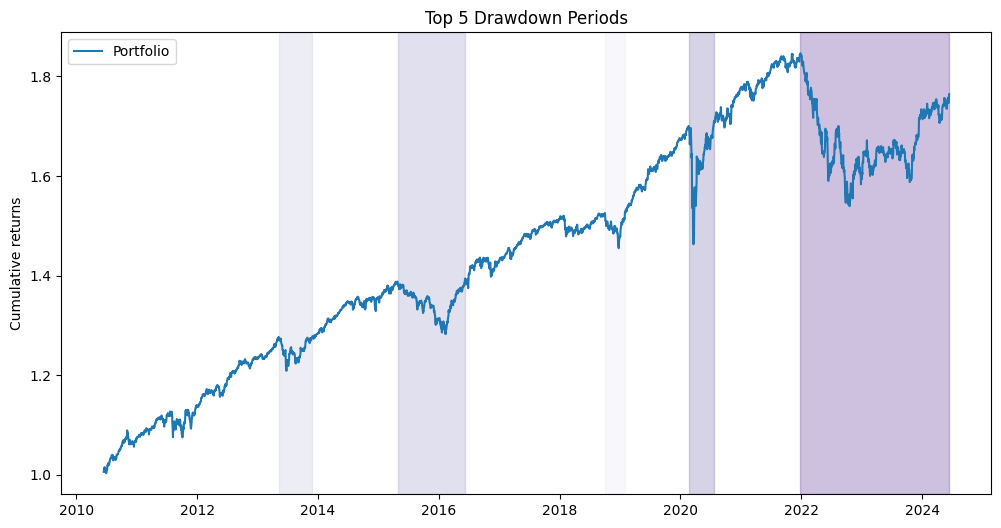

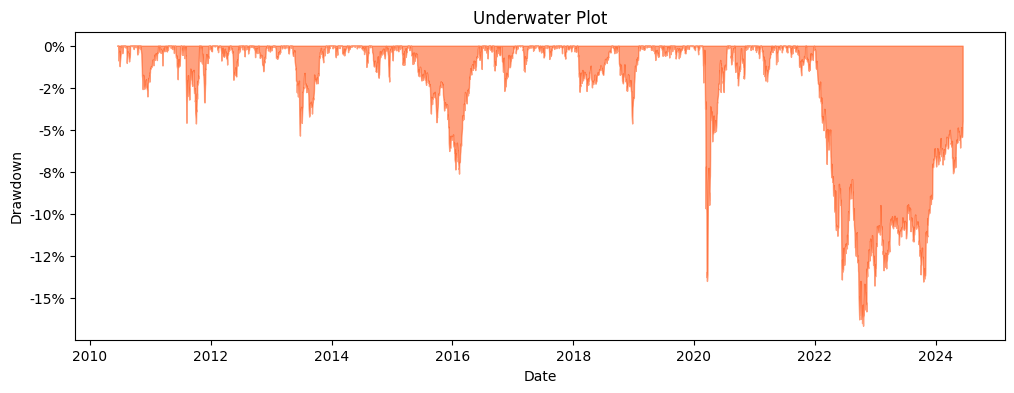

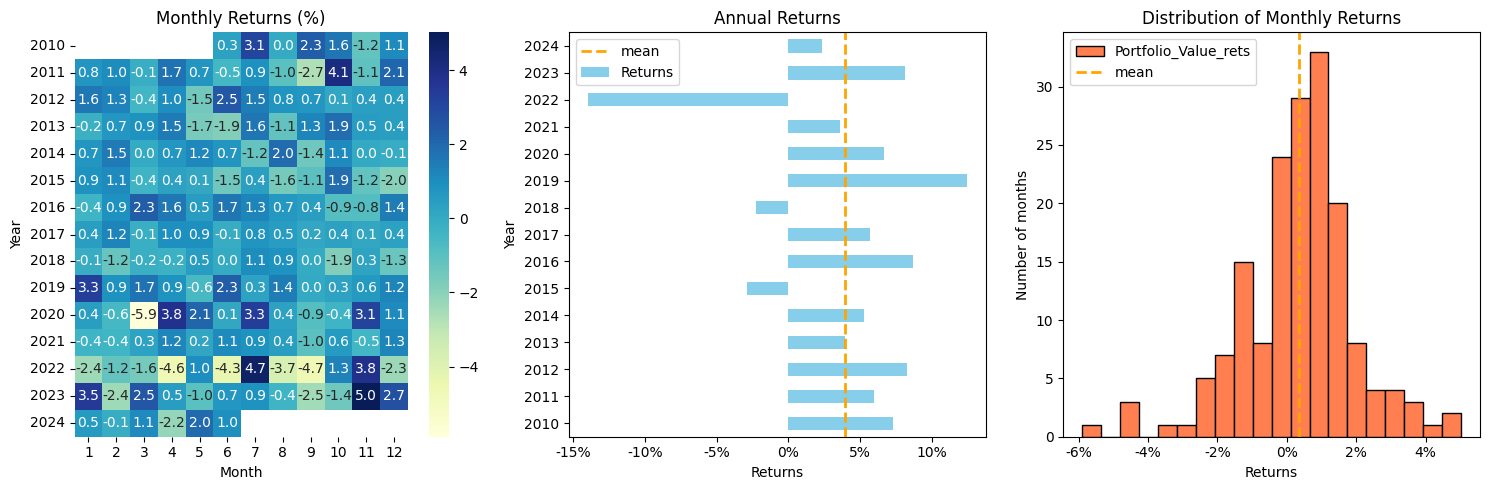

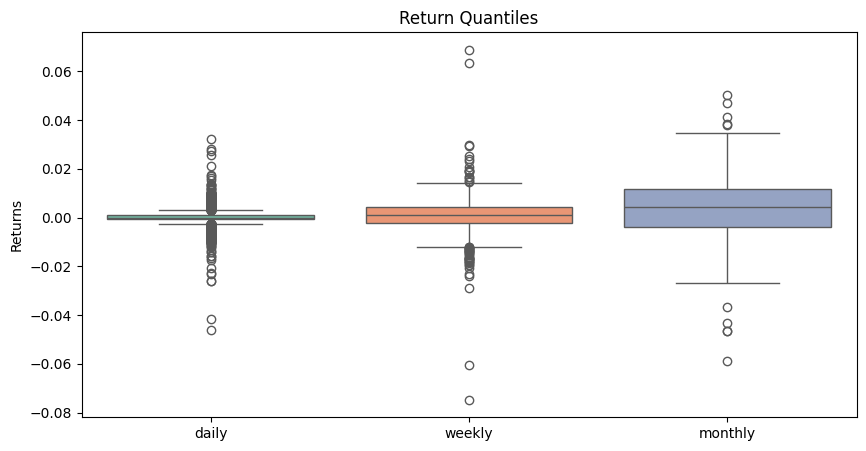

In [20]:
returns = stock_data['Portfolio_Value_rets']
plot_cumulative_return(returns)
plot_rolling_sharpe_ratio(returns, window=126)
plot_top_drawdowns(returns, top_n=5)
plot_underwater(returns)
# plot_weekly_returns_analysis(returns)
# plot_day_weekly_returns_analysis(returns)
plot_returns_analysis(returns)
plot_return_quantiles(returns)